In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

In [2]:
# Đọc dữ liệu
df1 = pd.read_csv('Transactions.csv')
df2 = pd.read_csv('Products_with_Categories.csv')

In [3]:
df1.head(5)

,Member_number,Date,productId,items
0,1808,21-07-2015,1,3
1,2552,05-01-2015,2,1
2,2300,19-09-2015,3,3
3,1187,12-12-2015,4,3
4,3037,01-02-2015,2,1


In [4]:
df2.head(5)

,productId,productName,price,Category
0,1,tropical fruit,7.8,Fresh Food
1,2,whole milk,1.8,Dairy
2,3,pip fruit,3.0,Fresh Food
3,4,other vegetables,0.8,Fresh Food
4,5,rolls/buns,1.2,Bakery & Sweets


In [5]:
df = pd.merge(df1, df2, on='productId', how='left').fillna('')
df.head(5)

,Member_number,Date,productId,items,productName,price,Category
0,1808,21-07-2015,1,3,tropical fruit,7.8,Fresh Food
1,2552,05-01-2015,2,1,whole milk,1.8,Dairy
2,2300,19-09-2015,3,3,pip fruit,3.0,Fresh Food
3,1187,12-12-2015,4,3,other vegetables,0.8,Fresh Food
4,3037,01-02-2015,2,1,whole milk,1.8,Dairy


In [75]:
df
df.to_csv('df_customer.csv', index= False)

In [7]:
# Tạo order id với giả sử thông tin lưu trên một hàng của dữ liệu cung cấp là một transaction
df['order_id'] = range(1,len(df['Member_number'])+1)
df.head(5)
df.to_excel('df.xlsx')

In [8]:
df.shape

(38765, 8)

In [9]:
df.columns

Index(['Member_number', 'Date', 'productId', 'items', 'productName', 'price',
       'Category', 'order_id'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Member_number  38765 non-null  int64  
 1   Date           38765 non-null  object 
 2   productId      38765 non-null  int64  
 3   items          38765 non-null  int64  
 4   productName    38765 non-null  object 
 5   price          38765 non-null  float64
 6   Category       38765 non-null  object 
 7   order_id       38765 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 2.4+ MB


In [11]:
# Chuyển kiểu dữ liệu ngày tháng từ kiểu object thành kiểu datetime
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y").date()

df['Date'] = df['Date'].apply(string_to_date)
df['Date'] = df['Date'].astype('datetime64[ns]')

In [12]:
df.dtypes

Member_number             int64
Date             datetime64[ns]
productId                 int64
items                     int64
productName              object
price                   float64
Category                 object
order_id                  int64
dtype: object

In [13]:
# Kiểm tra dữ liệu bị thiếu, bị trùng và xử lí
df.isnull().sum()

Member_number    0
Date             0
productId        0
items            0
productName      0
price            0
Category         0
order_id         0
dtype: int64

In [14]:
df.isna().sum()

Member_number    0
Date             0
productId        0
items            0
productName      0
price            0
Category         0
order_id         0
dtype: int64

In [15]:
df.duplicated().any()

np.False_

In [16]:
# Kiểm tra ngày giao dịch trễ nhất và sớm nhất
print('-'*20)
print('Transactions timeframe from {} to {}'.format(df['Date'].min(), df['Date'].max()))
# Kiểm tra giao dịch không có lưu thông tin id của khách hàng
print('-'*20)
print('{:,} transactions don\'t have a member number'.format(df[df.Member_number.isnull()].shape[0]))
# Kiểm tra có bao nhiêu khách hàng giao dịch
print('-'*20)
print('{:,} unique member number'.format(len(df.Member_number.unique())))

--------------------
Transactions timeframe from 2014-01-01 00:00:00 to 2015-12-30 00:00:00
--------------------
0 transactions don't have a member number
--------------------
3,898 unique member number


In [17]:
# Tính tiền mỗi lần giao dịch
df['gross_sales'] = df['items']*df['price']
df.head(5)

,Member_number,Date,productId,items,productName,price,Category,order_id,gross_sales
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food,1,23.4
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy,2,1.8
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food,3,9.0
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food,4,2.4
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy,5,1.8


In [18]:
# Viết hàm tạo RFM cho mỗi khách hàng
# Tính ngày giao dịch gần nhất của dữ liệu
max_date = df['Date'].max().date()

# Tính R: số ngày kể từ ngày giao dịch gần nhất đến ngày giao dịch của mỗi khách hàng
Recency = lambda x : (max_date - x.max().date()).days

# Tính F: tính số lần giao dịch của mỗi khách hàng dựa vào số id của order.
Frequency  = lambda x: len(x.unique())

# Tính M: tính tổng số tiền đã mua của mỗi khách hàng
Monetary = lambda x : round(sum(x), 2)

In [19]:
# RFM
df_RFM = df.groupby('Member_number').agg({'Date': Recency,
                                        'order_id': Frequency,
                                        'gross_sales': Monetary })
df_RFM.head()

,Date,order_id,gross_sales
Member_number,,,
1000,35,13,53.80
1001,242,12,100.00
1002,122,8,70.30
1003,323,8,60.65
1004,28,21,204.96


In [20]:
# Đổi tên cột và sắp xếp theo số tiền mua hàng giảm dần
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2743,142,17,312.46


In [21]:
df_RFM.tail()

,Recency,Frequency,Monetary
Member_number,,,
4565,0,2,2.2
3949,273,2,2.1
1560,593,2,1.9
1221,410,2,1.7
1250,448,2,1.3


# Nhận xét:
    - KH 2433 R:3 F:31 M:375
    - KH 1250 R 448 F:2 M: 1.3

In [70]:
# Thống kê mô tả
df_RFM['Recency'].describe()

count    3898.000000
mean      187.701385
std       159.912688
min         0.000000
25%        57.000000
50%       141.000000
75%       280.000000
max       727.000000
Name: Recency, dtype: float64

In [72]:
df_RFM['Frequency'].describe()

count    3898.000000
mean        9.944844
std         5.310796
min         2.000000
25%         6.000000
50%         9.000000
75%        13.000000
max        36.000000
Name: Frequency, dtype: float64

In [73]:
df_RFM['Monetary'].describe()

count    3898.000000
mean       85.212835
std        55.620089
min         1.300000
25%        43.810000
50%        74.900000
75%       115.295000
max       375.310000
Name: Monetary, dtype: float64

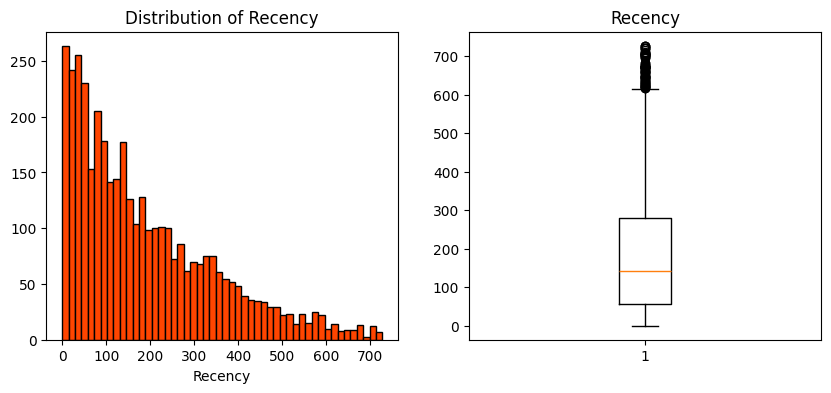

In [ ]:
# Vẽ phân phối của 'Recency'
plt.subplots(1,2, figsize = (10,4))


plt.subplot(1,2,1)
plt.hist(df_RFM['Recency'], bins=50, edgecolor='black', color = 'orangered')
plt.title('Distribution of Recency')
plt.xlabel('Recency')

plt.subplot(1,2,2)
plt.boxplot(df_RFM['Recency'])
plt.title('Recency')
plt.show()
plt.show()

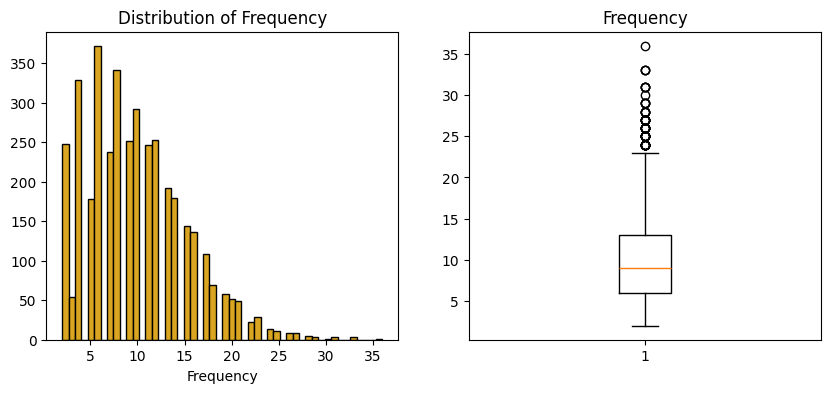

In [ ]:
# Vẽ phân phối của 'Frequency'
plt.subplots(1,2, figsize = (10,4))


plt.subplot(1,2,1)
plt.hist(df_RFM['Frequency'], bins=50, edgecolor='black', color = 'goldenrod')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

plt.subplot(1,2,2)
plt.boxplot(df_RFM['Frequency'])
plt.title('Frequency')
plt.show()
plt.show()

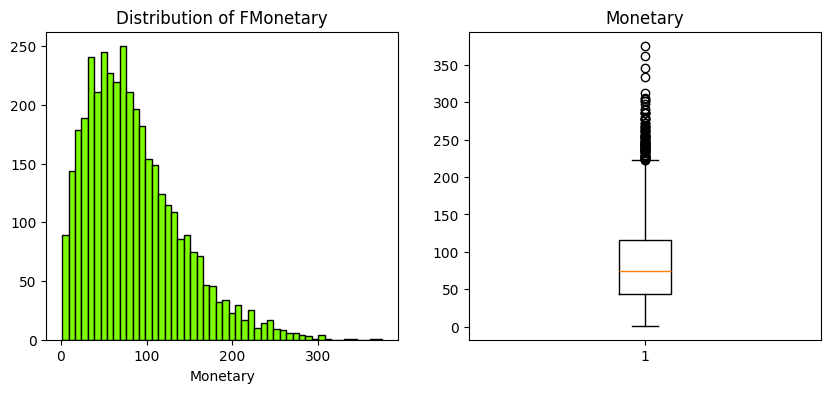

In [69]:
# Vẽ phân phối của 'Monetary'
plt.subplots(1,2, figsize = (10,4))


plt.subplot(1,2,1)
plt.hist(df_RFM['Monetary'], bins=50, edgecolor='black', color = 'lawngreen')
plt.title('Distribution of FMonetary')
plt.xlabel('Monetary')

plt.subplot(1,2,2)
plt.boxplot(df_RFM['Monetary'])
plt.title('Monetary')
plt.show()
plt.show()

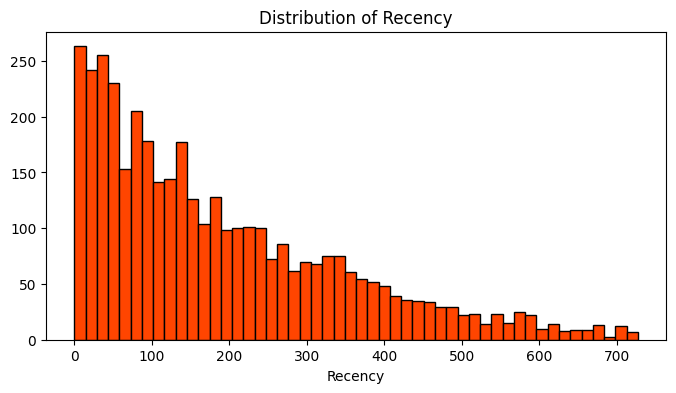

In [53]:
# Vẽ phân phối của 'Recency'
plt.figure(figsize = (8,4)) 
plt.hist(df_RFM['Recency'], bins=50, edgecolor='black', color = 'orangered')
plt.title('Distribution of Recency')
plt.xlabel('Recency')
plt.show()

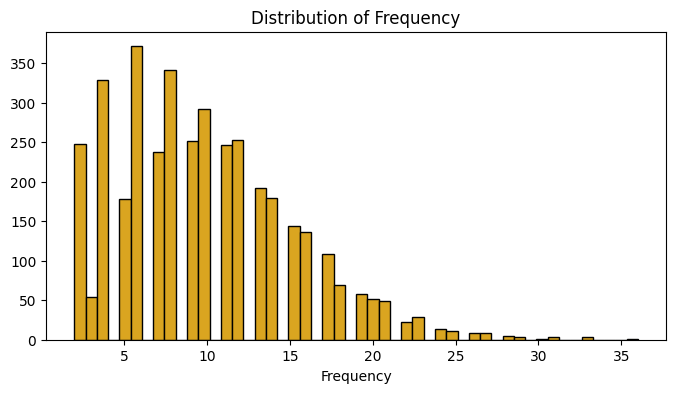

In [54]:
# Vẽ phân phối của 'Frequency'
plt.figure(figsize = (8,4))
plt.hist(df_RFM['Frequency'], bins=50, edgecolor='black', color = 'goldenrod')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')
plt.show()

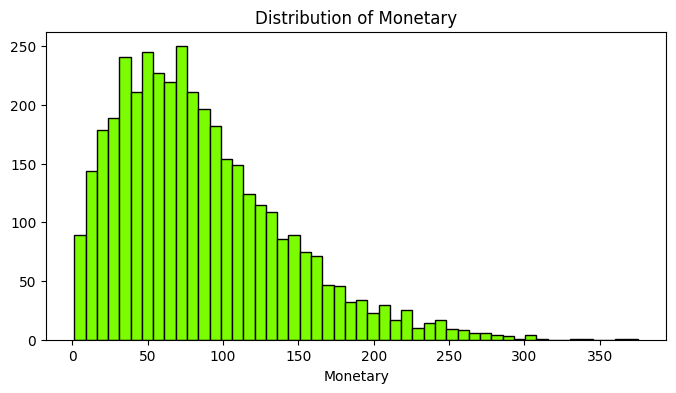

In [55]:
# Vẽ phân phối của 'Monetary'
plt.figure(figsize = (8,4))
plt.hist(df_RFM['Monetary'], bins=50, edgecolor='black', color = 'lawngreen')
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')
plt.show()


In [25]:
df_RFM['Recency'].skew(), df_RFM['Frequency'].skew(), df_RFM['Monetary'].skew()

(np.float64(1.0442386313591),
 np.float64(0.7813267387237887),
 np.float64(1.0423899887534855))

In [26]:
# Nhận xét: cả 3 phân bố đều lệch sang trái. Recency và Monetery lệch sang trái nhiều hơn so với Frequency.

In [27]:
df_RFM['Recency'].kurtosis(), df_RFM['Frequency'].kurtosis(), df_RFM['Monetary'].kurtosis()

(np.float64(0.47830440899310656),
 np.float64(0.6590394110398372),
 np.float64(1.246048482458535))

In [28]:
# Nhận xét: cả 3 phân bố đều có đỉnh cao hơn phân bố chuẩn

In [29]:
# Tạo RFM quartiles
# Create labels for Recency, Frequency, Monetary
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

In [30]:
# Assign these labels to 5 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=5, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=5, labels=f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=5, labels=m_labels)

In [31]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
Member_number,,,,,,
2433,3,31,375.31,5,5,5
2193,91,27,361.45,4,5,5
1793,26,25,345.10,5,5,5
3289,4,29,334.15,5,5,5
2743,142,17,312.46,3,5,5


In [32]:
### Concat RFM quartile values to create RFM Segments

In [33]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
Member_number,,,,,,,
2433,3,31,375.31,5,5,5,555
2193,91,27,361.45,4,5,5,455
1793,26,25,345.10,5,5,5,555
3289,4,29,334.15,5,5,5,555
2743,142,17,312.46,3,5,5,355


In [34]:
#### Count num of unique segments
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
rfm_count_unique.sum()

np.int64(111)

In [35]:
###Having 60 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

In [36]:
#### Calculate RFM score and level
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM['RFM_Score'].min(), df_RFM['RFM_Score'].max()

(np.int64(3), np.int64(15))

#### 1. Phân cụm khách hàng dựa vào Kmeans

In [37]:
df_now = df_RFM[['Recency','Frequency','Monetary']]
df_now

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2743,142,17,312.46
...,...,...,...
4565,0,2,2.20
3949,273,2,2.10
1560,593,2,1.90


In [38]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_now)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

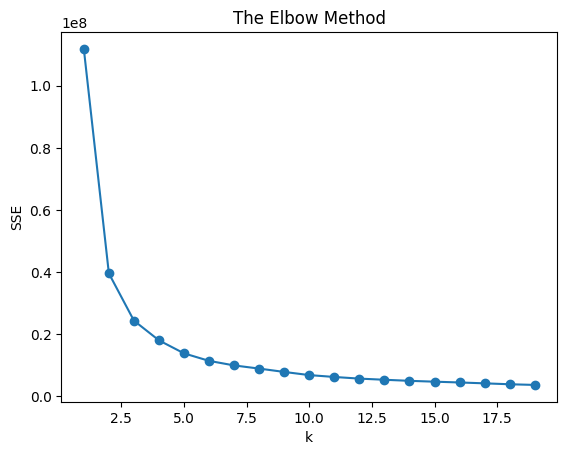

In [39]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [40]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df_now)
model.labels_.shape

(3898,)

In [41]:
x = pd.DataFrame({'Recency': 1, 'Frequency': 30, 'Monetary': 100}, index = [1])
x

,Recency,Frequency,Monetary
1,1,30,100


In [42]:
y = model.predict(x)
y

array([4], dtype=int32)

In [43]:
import pickle
model_file_name = 'customer_segmentation_kmeans_model.pkl'
with open(model_file_name, 'wb') as f:
    pickle.dump(model, f)

In [44]:
with open('customer_segmentation_kmeans_model.pkl', 'rb') as f:
    model_ = pickle.load(f)
model_.predict(x)

array([4], dtype=int32)

In [45]:
df_now

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2743,142,17,312.46
...,...,...,...
4565,0,2,2.20
3949,273,2,2.10
1560,593,2,1.90


In [46]:
df_now.index

Index([2433, 2193, 1793, 3289, 2743, 2811, 2990, 3872, 4753, 2993,
       ...
       4029, 4926, 1314, 1039, 3162, 4565, 3949, 1560, 1221, 1250],
      dtype='int64', name='Member_number', length=3898)

In [47]:
df_now.loc[[2433]]
df_now [(df_now['Recency']==3)  &  (df_now['Frequency']==31) & (df_now['Monetary']==375.31)]

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31


In [48]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

C:\Users\Thu\AppData\Local\Temp\ipykernel_1432\1766179631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_now["Cluster"] = model.labels_


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         63.76     17.14   175.45   611
1        553.06      4.56    37.77   322
2        188.81      9.54    78.50  1051
3        345.98      7.37    62.84   726
4         54.71      9.64    71.28  1188

In [49]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_now.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,64.0,17.0,175.0,611,15.67
1,Cluster 1,553.0,5.0,38.0,322,8.26
2,Cluster 2,189.0,10.0,78.0,1051,26.96
3,Cluster 3,346.0,7.0,63.0,726,18.62
4,Cluster 4,55.0,10.0,71.0,1188,30.48


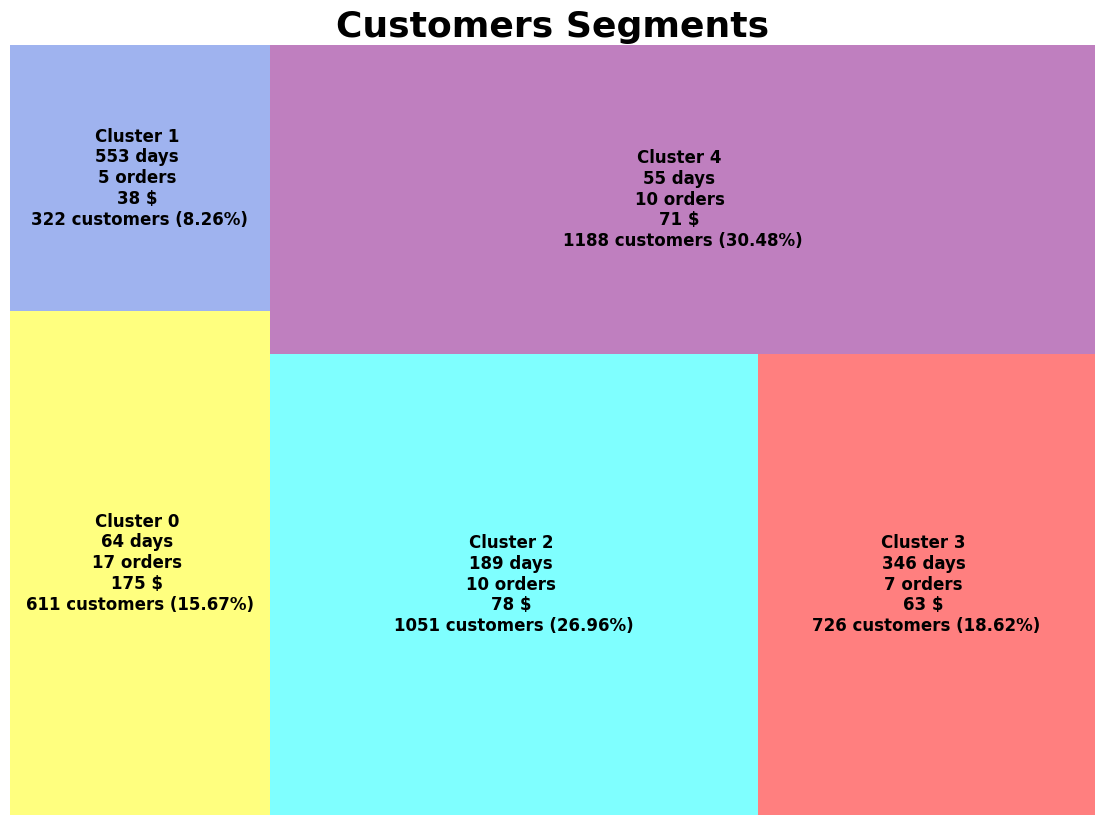

In [50]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Unsupervised Segments.png')
plt.show()

In [51]:
# Nhận xét 1:
# Cluster 0 chiếm 15.67%: Nhóm khách hàng này số ngày trung bình mua hàng gần nhất khá nhỏ 64 ngày, đứng thứ nhì trong 6
# nhóm, số giao dịch trung bình là cao nhất 17 giao dịch và số tiền giao dịch trung bình cũng cao nhất
# nên đây là nhóm khách hàng VIP. Cần có chiến lược để giữ chân nhóm này, cũng như kích thích mua hàng ở nhóm này.
# Cluster 1 chiếm 7.7%: Nhóm này có số ngày trung bình mua hàng gần nhất rất lớn, gần 1.5 năm, số đơn mua hàng rất ít, chỉ trung
# bình 4 đơn hàng, đồng thời giá trị trung bình mỗi đơn hàng là thấp nhất trong 5 năm nên nhóm này có khả  năng rời
# đi cao nhất hoặc đã rời đi.
# Cluster 2 chiếm 30.71%: nhóm này có thời gian mua hàng trung bình gần nhất là nhỏ nhất trong tất cả các nhóm là 55 ngày.
# Số lượng đơn hàng giao dịch trung bình lớn thứ nhì là 10 đơn hàng, giá trị mỗi đơn hàng cao thứ 3 là 71$ nên nhóm
# này là khách hàng mới và rất có tiềm năng thành khách hàng VIP. Cần tích cực chăm sóc khách hàng này.
# Cluster 3 chiếm 18.32%: nhóm này có thời gian giao dịch gần nhất khá lớn là 353 ngày, lớn thứ nhì trong 5 nhóm,
# số lượng đơn hàng thấp thứ nhì, chỉ 7 đơn hàng và giá trị đơn hàng 62$ cao thứ 4. Nhóm này là nhóm mang lại lợi nhuận ít
# và có khả năng rời đi rất cao. Cần có chiến lược quảng cáo, tiếp thị và các chương trình khuyến mãi dể giữ chân nhóm này
# Cluster 4 chiếm 27.8%: nhóm này có thời gian giao dịch, giá trị đơn hàng, và giá trị mỗi giao dịch là trung bình trong
# 5 nhóm. Nên nhóm này rơi vào nhóm bình thường. Nhóm này tuy không mang lợi nhuận cao nhất nhưng mang tính ổn định
# cho việc kinh doanh của cửa hàng. Cần có chiến lược để củng cố lượng khách này như các chương trình tri ân khách hàng.
# nhóm này gắn bó lâu dài với cửa hàng.

# Nhận xét 2:
# Thuật toán Kmeans phân cụm khách hàng trong trường hợp này khá tốt. Có sự tách biệt khá rõ giữa đặc điểm
# của các nhóm. Giúp cho chủ cửa hàng có những chiến lược chăm sóc, tiếp thị, khuyển mãi hiệu quả đến từng nhóm khách hàng
#

In [52]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Manual Segmentation


In [ ]:
def rfm_level(df):
    # Check for special 'STARS' and 'NEW' conditions first
    if df['RFM_Score'] >=14:
        return 'VIP' # mua hàng gần nhất, đơn hàng giá trị cao nhất và số lần giao dịch cao nhất
    elif df['F'] >=4 and df['M']>=4 and df['R'] >= 3 and df['RFM_Score'] < 14:
        return 'Loyal Customers' # số lần giao dịch cao nhất, đơn hàng giá trị cao nhất nhưng không xuất hiện gần nhất. 
    elif (df['R'] == 2 or df['R'] == 3) and (df['F'] == 2 or df['F'] == 3) and (df['M'] == 2 or df['M'] == 3):
        return 'Light' # khách hàng tiềm năng thành khách hàng trung thành 
    elif df['R'] <= 2:
        return 'At-Risk Customers' # khách hàng lâu rồi không xuất hiện nên có khả năng rời đi
    elif df['M'] ==1 and  df['F'] ==1 and df['R'] ==5:
        return 'New Customers'# khách hàng mới xuất hiện, giao dịch còn ít và còn thăm dò cửa hàng
    else: 
        return 'Regulars' # Khách hàng thông thường

In [ ]:
df_RFM

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Member_number,,,,,,,,
2433,3,31,375.31,5,5,5,555,15
2193,91,27,361.45,4,5,5,455,14
1793,26,25,345.10,5,5,5,555,15
3289,4,29,334.15,5,5,5,555,15
2743,142,17,312.46,3,5,5,355,13
...,...,...,...,...,...,...,...,...
4565,0,2,2.20,5,1,1,511,7
3949,273,2,2.10,2,1,1,211,4
1560,593,2,1.90,1,1,1,111,3


In [ ]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

In [ ]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
Member_number,,,,,,,,,
2433,3,31,375.31,5,5,5,555,15,VIP
2193,91,27,361.45,4,5,5,455,14,VIP
1793,26,25,345.10,5,5,5,555,15,VIP
3289,4,29,334.15,5,5,5,555,15,VIP
2743,142,17,312.46,3,5,5,355,13,Loyal Customers


In [ ]:
#### Number of segments

In [ ]:
df_RFM['RFM_Level'].value_counts()

RFM_Level
At-Risk Customers    1333
Regulars             1141
Loyal Customers       529
VIP                   434
Light                 419
New Customers          42
Name: count, dtype: int64

In [ ]:
#### Calculate mean values for each segment

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [ ]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,At-Risk Customers,366.0,8.0,65.0,1333,34.20
1,Light,203.0,8.0,63.0,419,10.75
2,Loyal Customers,98.0,14.0,130.0,529,13.57
3,New Customers,17.0,3.0,20.0,42,1.08
4,Regulars,78.0,8.0,66.0,1141,29.27
5,VIP,39.0,18.0,172.0,434,11.13


In [ ]:
#### TreeMap

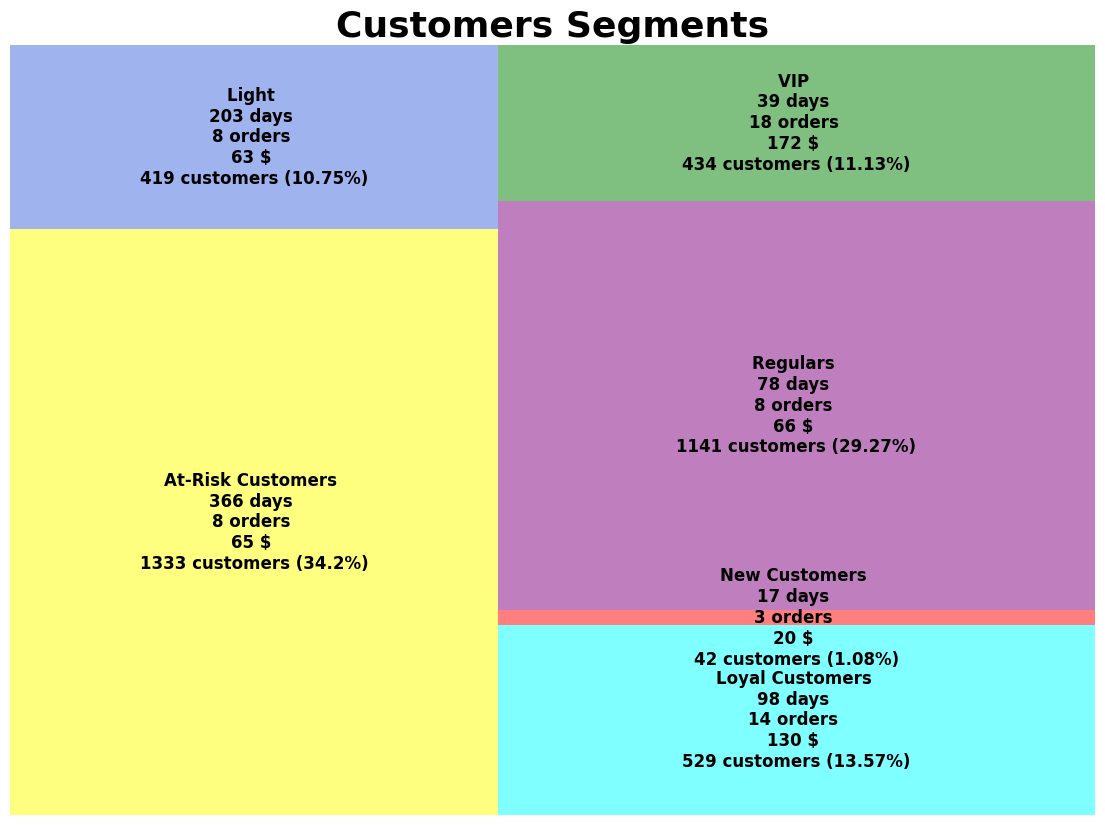

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [ ]:
#### Scatter Plot (RFM)

In [ ]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

c:\Users\Thu\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
# Nhận xét: khi phân tách các nhóm bằng tập luật dễ dẫn đến sự chồng chéo và mất cân bằng của các nhóm
# Tuy nhiên khi phân tích bằng tập luật sẽ dễ giải thích kết quả đồng thời có thế tìm ra được nhóm
# đặc biệt rất rõ ràng. Ví dự khách hàng VIP, khách hàng mới và khách hàng rời đi. Đây là những nhóm dễ dàng
# xác định bằng tập luật.

# GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_RFM[['Recency', 'Frequency', 'Monetary']])

In [ ]:
log_likelihoods = []
bics = []
aics = []
num_clusters = range(1, 11)  # Chạy từ 1 đến 10 cụm

for k in num_clusters:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_scaled)  # df_now_scaled là dữ liệu đã scale
    
    log_likelihoods.append(gmm.score(df_scaled) * len(df_scaled))
    bics.append(gmm.bic(df_scaled))
    aics.append(gmm.aic(df_scaled))

# Chuyển về mảng numpy để dễ thao tác
log_likelihoods = np.array(log_likelihoods)
bics = np.array(bics)
aics = np.array(aics)

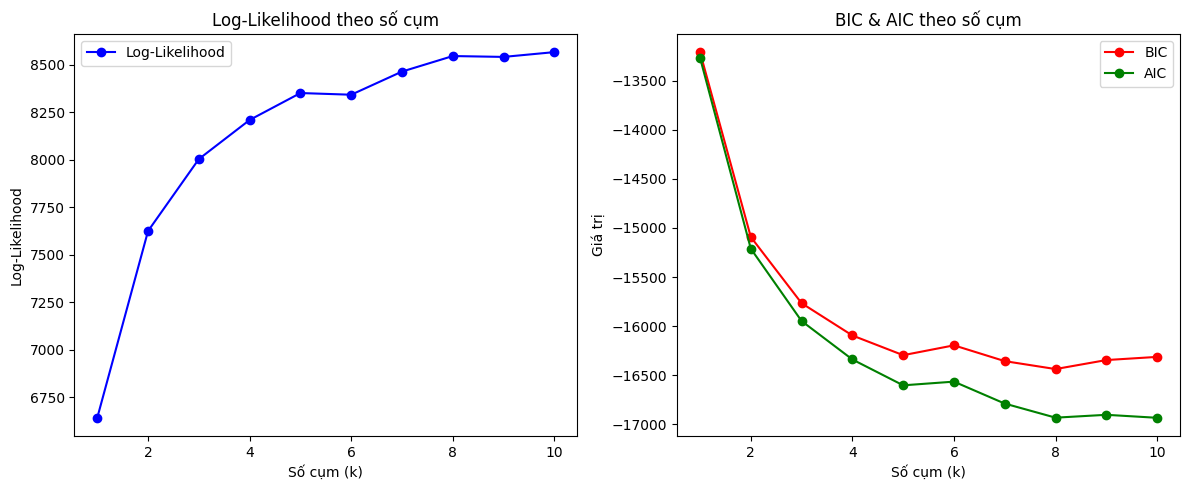

In [ ]:
plt.figure(figsize=(12, 5))

# Vẽ Log-Likelihood
plt.subplot(1, 2, 1)
plt.plot(num_clusters, log_likelihoods, marker='o', linestyle='-', color='blue', label="Log-Likelihood")
plt.xlabel("Số cụm (k)")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood theo số cụm")
plt.legend()

# Vẽ BIC & AIC
plt.subplot(1, 2, 2)
plt.plot(num_clusters, bics, marker='o', linestyle='-', color='red', label="BIC")
plt.plot(num_clusters, aics, marker='o', linestyle='-', color='green', label="AIC")
plt.xlabel("Số cụm (k)")
plt.ylabel("Giá trị")
plt.title("BIC & AIC theo số cụm")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
log_likelihood = gmm.score(df_scaled) * len(df_scaled)
print(f"Log-Likelihood: {log_likelihood}")

Log-Likelihood: 8566.06970959339


In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42)
df_RFM['Cluster_GMM'] = gmm.fit_predict(df_scaled)

df_RFM.head() 

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Cluster_GMM
Member_number,,,,,,,,,,
2433,3,31,375.31,5,5,5,555,15,VIP,2
2193,91,27,361.45,4,5,5,455,14,VIP,2
1793,26,25,345.10,5,5,5,555,15,VIP,2
3289,4,29,334.15,5,5,5,555,15,VIP,2
2743,142,17,312.46,3,5,5,355,13,Loyal Customers,2


In [ ]:
import plotly.express as px

df_RFM['Cluster_GMM'] = gmm.fit_predict(df_scaled)

fig = px.scatter(df_RFM, x="Recency", y="Monetary", 
                 color=df_RFM["Cluster_GMM"].astype(str), 
                 title="Phân cụm khách hàng theo GMM",
                 labels={"Cluster_GMM": "Nhóm cụm"},
                 opacity=0.8)

fig.show()



c:\Users\Thu\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
import plotly.express as px

# Thêm cột Cluster_GMM nếu chưa có
df_RFM['Cluster_GMM'] = gmm.fit_predict(df_scaled)

# Vẽ biểu đồ 3D
fig = px.scatter_3d(df_RFM, 
                    x="Recency", 
                    y="Frequency", 
                    z="Monetary", 
                    color=df_RFM["Cluster_GMM"].astype(str),  # Đổi thành chuỗi để vẽ màu
                    title="Phân cụm khách hàng theo GMM (3D)",
                    labels={"Cluster_GMM": "Nhóm cụm"},
                    opacity=0.8)

fig.show()

c:\Users\Thu\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
import plotly.express as px
import pandas as pd

# Tạo DataFrame tổng hợp cho từng cụm
rfm_agg_gmm = df_RFM.groupby('Cluster_GMM').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# Thêm số lượng khách hàng mỗi cụm
rfm_agg_gmm['Count'] = df_RFM['Cluster_GMM'].value_counts()
rfm_agg_gmm['Percent'] = round((rfm_agg_gmm['Count'] / rfm_agg_gmm['Count'].sum()) * 100, 2)

# Reset index
rfm_agg_gmm = rfm_agg_gmm.reset_index()
rfm_agg_gmm['Cluster_GMM'] = 'Cluster ' + rfm_agg_gmm['Cluster_GMM'].astype(str)

# Vẽ biểu đồ scatter plot
fig_gmm = px.scatter(rfm_agg_gmm, 
                      x="Recency", 
                      y="Monetary", 
                      size="Frequency", 
                      color="Cluster_GMM",
                      hover_name="Cluster_GMM", 
                      size_max=100, 
                      title="Phân cụm khách hàng bằng GMM")

fig_gmm.show()


c:\Users\Thu\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



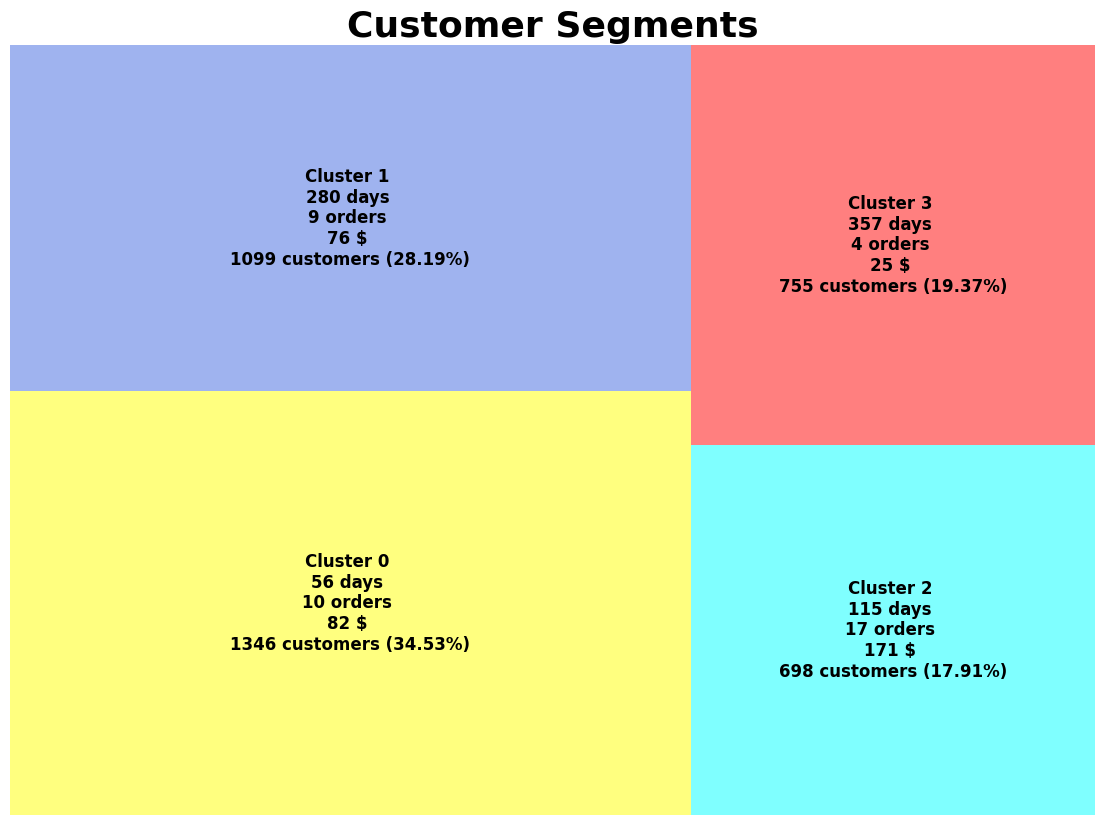

In [ ]:
import squarify

# Tạo figure và định dạng
fig = plt.gcf()
fig.set_size_inches(14, 10)
ax = fig.add_subplot()

# Tạo dictionary màu sắc cho từng cụm
colors_dict_gmm = {
    'Cluster 0': 'yellow',
    'Cluster 1': 'royalblue',
    'Cluster 2': 'cyan',
    'Cluster 3': 'red',
    'Cluster 4': 'purple'
}

# Vẽ Treemap với dữ liệu từ rfm_agg_gmm
squarify.plot(
    sizes=rfm_agg_gmm['Count'], 
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    color=[colors_dict_gmm[label] for label in rfm_agg_gmm['Cluster_GMM']], 
    label=[
        '{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(
            *rfm_agg_gmm.iloc[i]
        ) for i in range(len(rfm_agg_gmm))
    ],
    alpha=0.5
)

# Thêm tiêu đề và ẩn trục
plt.title("Customer Segments", fontsize=26, fontweight="bold")
plt.axis('off')

# Hiển thị biểu đồ
plt.show()